<a href="https://colab.research.google.com/github/chuancao26/islp/blob/main/LabNonLinearApproach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ISLP

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 7.5 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=8c17340e0c2201ac5ce90139ee71caaaff33453c10535ca39de6bed697884b08
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


imports iniciales

In [2]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import statsmodels.api as sm

from ISLP import load_data
from ISLP.models import (summarize,
                        poly,
                        ModelSpec as MS)
from statsmodels.stats.anova import anova_lm

New imports

In [3]:
from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)
from ISLP.transforms import (BSpline,
                             NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)

# Polynomial regression and Step Functions

In [4]:
# cargando la data
df = load_data('Wage')
y = df["wage"]
age = df["age"]


In [5]:
# vamos a fittear una 4-d polinomial regression.
poly_age = MS([poly("age", degree=4)]).fit(df)
M = sm.OLS(y, poly_age.transform(df)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


In [6]:
age_grid = np.linspace(age.min(), age.max(), 100)
age_df = pd.DataFrame({"age": age_grid})

Generador de graficos con una basis transformation

In [7]:
def plot_wage_fit(age_df,
                  basis,
                  title):
  X = basis.transform(df)
  Xnew = basis.transform(age_df)
  M = sm.OLS(y, X).fit()
  preds = M.get_prediction(Xnew)
  bands = preds.conf_int(alpha=0.05)
  fig, ax = plt.subplots(figsize=(8,8))
  ax.scatter(age, y,
             facecolor="gray",
             alpha=.5)
  for val, ls in zip([preds.predicted_mean, bands[:, 0], bands[:, 1]],
                      ["b", "r--", "r--"]):
    ax.plot(age_df.values, val, ls, linewidth=2)
  ax.set_title(title, fontsize=20)
  ax.set_xlabel("Age", fontsize=20)
  ax.set_ylabel("Wage", fontsize=20)
  return ax

<Axes: title={'center': 'Degree-4 polynomial'}, xlabel='Age', ylabel='Wage'>

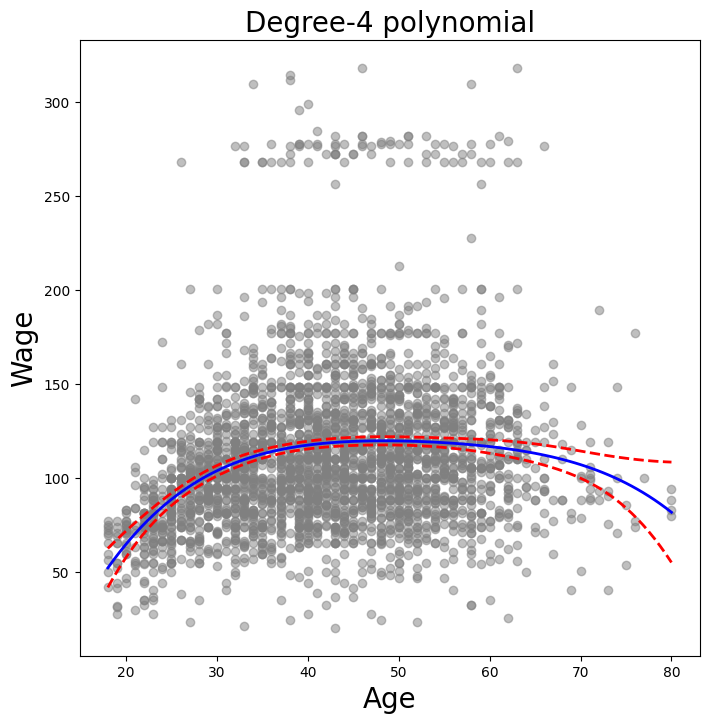

In [8]:
plot_wage_fit(age_df,
              poly_age,
              "Degree-4 polynomial")

In [10]:
 # veamos un grafico con diferentes degrees polynomial
models = [MS([poly("age", degree=d)]) for d in range(1, 6)]
Xs = [model.fit_transform(df) for model in models]
anova_lm(*[sm.OLS(y, X_).fit() for X_ in Xs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


In [11]:
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


Ahora veamos el caso de una regresion Logistica

In [12]:
X = poly_age.transform(df)
high_earn = df["high_earn"] = y < 250

glm = sm.GLM(high_earn,
             X,
               family=sm.families.Binomial())
B = glm.fit()
summarize(B)


,coef,std err,z,P>|z|
intercept,4.3012,0.345,12.457,0.000
"poly(age, degree=4)[0]",-71.9642,26.133,-2.754,0.006
"poly(age, degree=4)[1]",85.7729,35.929,2.387,0.017
"poly(age, degree=4)[2]",-34.1626,19.697,-1.734,0.083
"poly(age, degree=4)[3]",47.4008,24.105,1.966,0.049


In [15]:
newX = poly_age.transform(age_df)
preds = B.get_prediction(newX)
bands = preds.conf_int(alpha=0.05)

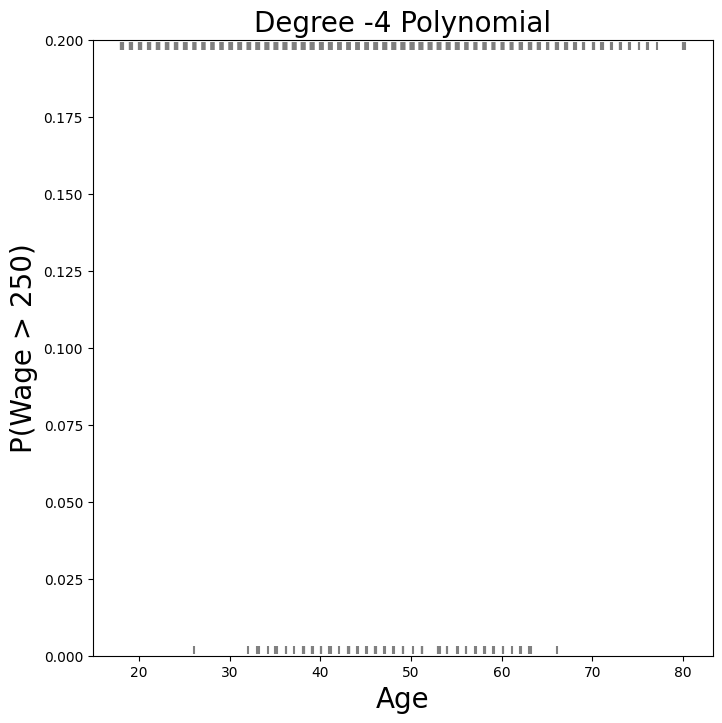

In [25]:
fig, ax = plt.subplots(figsize=(8,8))
rng = np.random.default_rng(0)
ax.scatter(age +
           0.2 * rng.uniform(size=y.shape[0]),
           np.where(high_earn, 0.198, 0.002),
           fc='gray',
           marker='|')
for val, ls in zip([preds.predicted_mean ,
                    bands[:,0],
                    bands[:,1]],
                     ['b','r--','r--']):
  ax.plot(age_df.values, val, ls, linewidth=2)
ax.set_title('Degree -4 Polynomial', fontsize=20)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylim([0,0.2])
ax.set_ylabel('P(Wage > 250)', fontsize=20);

## Step Function (faltan graficos)

Vamos a ver el caso de pd.qcut para categorizar la variable age

In [20]:
cut_age = pd.qcut(age, 4)
summarize(sm.OLS(y, pd.get_dummies(cut_age)).fit())

,coef,std err,t,P>|t|
"(17.999, 33.75]",94.1584,1.478,63.692,0.0
"(33.75, 42.0]",116.6608,1.470,79.385,0.0
"(42.0, 51.0]",119.1887,1.416,84.147,0.0
"(51.0, 80.0]",116.5717,1.559,74.751,0.0


# Splines